In [2]:
%load_ext autoreload
%autoreload 2

# Imports & Helper Functions

In [3]:
# Built In / Helper
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from collections import deque
os.environ['JAX_PLATFORMS'] = 'cuda'

# Data
import dlimp
from dlimp.dataset import DLataset
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # No visible GPU! don't let the dataset clog up our GPU space! duh! 
import tensorflow_datasets as tfds
import jax.numpy as jnp
import jax


# Multinav
from multinav.data.load_data import load_dataset, setup_datasets, dataset_postprocess, DATASETS, dataset_preprocess
from multinav.utils.visualization import view_img, view_img_on_axes, traj_dataset_successes_print
from multinav.training.agent import Agent
from multinav.training.model_config import get_config as get_model_config

# Const
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406])
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225])

2024-08-12 11:50:20.706629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 11:50:20.706659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 11:50:20.707552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 11:50:20.712528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 11:50:21.306288: W tensorflow/compiler/tf2

ModuleNotFoundError: No module named 'jaxrl_m.vision.bigvision_resnetv2'

# LOAD DATA

## CREATE

In [11]:
# FROM TRAJ LEVEL DATASET, directly from TFDS 
dataset_name = "run_9_gs:0.0.1"
dataset_dir = "/home/lydia/data/create_data/finetuning/gc_cql_twist_dense_alpha1.0_proprioTrue_hist1_2024_07_19_22_33_54" 

dataset_builder = tfds.builder(dataset_name, data_dir=dataset_dir)
dataset = (
    DLataset.from_rlds(dataset_builder)
    .filter(lambda traj: traj["_len"][0] >= 4)
).ignore_errors(log_warning=True, name=f"ignore_errors")

dataset_iter = dataset.iterator()

2024-08-12 14:23:37.589026: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [ ]:
my_data, _ = setup_datasets(
    data_mix =  "finetuning_run_4_gs",
    data_dir = "/home/lydia/data/create_data/finetuning/gc_cql_twist_dense_skip1_alpha1.0_proprioTrue_2024_07_02_23_02_41/fine_100k",
    discount = 0.97,
    skip_crash = False,
    num_frame_skip=1,
    discrete=False,
    truncate_goal=False,
    validate=None,
    negative_probability=0.0,
    reward_type = "dense",
    action_type = "twist",
    image_size=64,
    history_len=5,
    prioritize_space= True,
    train_buffer_size=2500,
)
data_iter = my_data.iterator()

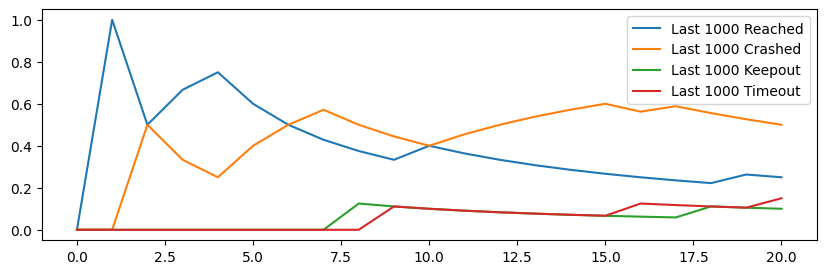

In [6]:
from multinav.utils.visualization import traj_dataset_successes_avgd, wandb_successes_avgd
traj_dataset_successes_avgd(dataset, 1000)

In [ ]:
wandb_path = "/home/lydia/data/create_data/finetuning/metrics/wandb_gc_cql_twist_dense_alpha1.0_proprioTrue_hist1_2024_07_19_22_33_54.csv"

wandb_successes_avgd(wandb_path)

# GNM

In [ ]:
# GNM DATASET
my_data, _ = setup_datasets(
    data_mix =  "gnm",
    data_dir = "/nfs/kun2/datasets/gnm_dataset_tensorflow",
    discount = 0.97,
    skip_crash = False,
    num_frame_skip=1,
    discrete=False,
    truncate_goal=False,
    validate=None,
    negative_probability=0.25,
    reward_type = "dense",
    action_type = "twist",
    image_size=64,
    history_len=5,
    prioritize_space= True,
)
data_iter = my_data.iterator()

## Visualizing Data

In [13]:
traj_dataset_successes_print(dataset)

9 trajectories with total len 2396 (avg len 266.22)
6 reached (0.67), 0 crashed, 1 keepouts, 2 timed out 


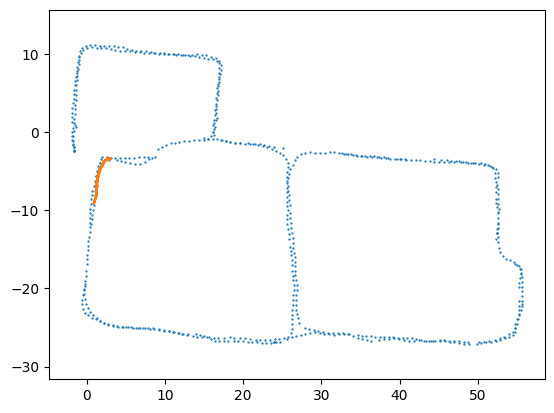

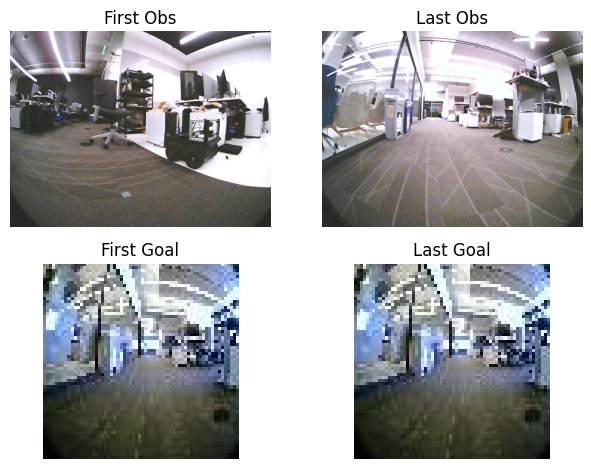

In [9]:
# GOAL LOOP UNDER
goal_loop = np.load("/home/lydia/data/goal_loops/npz/bair_loop.npz")
goal_positions = goal_loop["data/position"]
plt.scatter(goal_positions[:, 0], goal_positions[:, 1], s = 0.4)

pose_key = "position" # "position"
traj = next(dataset_iter)
plt.scatter(traj["observation"][pose_key][:, 0], traj["observation"][pose_key][:, 1], s = 0.4)
plt.axis('equal')
plt.show()

# view first, last, goals from 'trajectory'
fig, axes = plt.subplots(2, 2)
label_type = {0: "Obs", 1: "Goal"}
label_order = {0:"First", 1:"Last"}
for i in range(2):
    for j in range(2):
        axes[i, j].axis("Off")
        axes[i, j].set_title(f"{label_order[j]} {label_type[i]}")

view_img_on_axes(traj["observation"]["image"][0], axes[0, 0], scaling = False)
view_img_on_axes(traj["observation"]["goal"]["image"][0], axes[1, 0], scaling = False)

view_img_on_axes(traj["observation"]["image"][-1], axes[0, 1], scaling = False)
view_img_on_axes(traj["observation"]["goal"]["image"][-2], axes[1, 1], scaling = False)

plt.tight_layout()
plt.show()

In [ ]:
prev_actions = []
actions = []

for i in range(250):
    traj = next(data_iter)
    prev_actions.append(traj["observations"]["prev_action"][0])
    actions.append(traj["actions"][0])

plt.scatter(prev_actions, actions)
plt.show()

In [ ]:
prev_actions = []
actions = []

for i in range(250):
    traj = next(data_iter)
    prev_actions.append(traj["observations"]["prev_action"][1])
    actions.append(traj["actions"][1])

plt.scatter(prev_actions, actions)
plt.show()

In [ ]:
fig, axes = plt.subplots(1 , 5, figsize=(15, 3))

for i in range(5):
    # view_img_on_axes(traj["observations"]["image"][i], axes[i], scaling = True)
    # axes[i].imshow(traj["observations"]["image"][i])
    axes[i].imshow((traj["next_observations"]["image"][i] - traj["observations"]["image"][i]) * 0.2 + 0.4)

plt.show()

In [ ]:
traj = next(dataset_iter)

In [ ]:
plt.plot(traj["observation"]["linear_velocity"][:, 0])
plt.plot(traj["action"][:, 0])

In [ ]:
i = 25
traj["action"][i], traj["action"][i+1], traj["action"][i+2], traj["action"][i+3], traj["action"][i+4]

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
start = 25
for i in range(start, start+ 5):
    view_img_on_axes(tf.io.decode_image(traj["observation"]["image"][i], expand_animations=False), axes[i - start], scaling = False)
    # subplots[i - 10].imshow((np.array(tf.io.decode_image(traj["observation"]["image"][i+1], expand_animations=False), dtype=float)))

plt.show()


In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
start = 13
for i in range(start, start+ 5):
    view_img_on_axes((np.array(tf.io.decode_image(traj["observation"]["image"][i], expand_animations=False), dtype=float) - np.array(tf.io.decode_image(traj["observation"]["image"][i+1], expand_animations=False), dtype=float)) / 255 + 0.5, axes[i - start], scaling = False)
    # subplots[i - 10].imshow((np.array(tf.io.decode_image(traj["observation"]["image"][i+1], expand_animations=False), dtype=float)))

plt.show()


In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
start = 10
for i in range(start, start+ 5):
    view_img_on_axes(tf.io.decode_image(traj["observation"]["image"][i], expand_animations=False), axes[i - start], scaling = False)
    # subplots[i - 10].imshow((np.array(tf.io.decode_image(traj["observation"]["image"][i+1], expand_animations=False), dtype=float)))

plt.show()


In [ ]:
fig, subplots = plt.subplots(1, 5, figsize=(15, 3))
for i in range(10, 10 + 5):
    subplots[i- 10].imshow((np.array(tf.io.decode_image(traj["observation"]["image"][i+1], expand_animations=False), dtype=float) - np.array(tf.io.decode_image(traj["observation"]["image"][i], expand_animations=False), dtype=float)) / 50 + 0.5)

# FINE TUNING TEST

## ACTOR CHECK

In [ ]:
from agentlace.action import ActionClient
from multinav.utils.trainer_bridge_common import (
    make_action_config,
    make_trainer_config,
)
import numpy as np
import time

robot_ip = "192.168.68.57"
robot = ActionClient(
            robot_ip,
            make_action_config(),
        )

In [ ]:
while True:
    action = np.array([0, np.random.uniform(-0.2, 0.2)])
    robot.act("action_vw", action)
    time.sleep(0.25)

## SERVER CHECK

In [ ]:
import time
import jax.experimental
import jax.experimental.compilation_cache
import jax.experimental.compilation_cache.compilation_cache
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') 
tf.config.threading.set_inter_op_parallelism_threads(1)

from typing import Mapping
from agentlace.data.tf_agents_episode_buffer import EpisodicTFDataStore
from agentlace.trainer import TrainerServer
import wandb
import tqdm
import numpy as np

import sys 
import os

import jax
jax.experimental.compilation_cache.compilation_cache.initialize_cache("/tmp/jax_cc_lydia")
import flax
import jax.numpy as jnp
from jaxrl_m.vision.data_augmentations import batched_random_crop
from jaxrl_m.utils.timer_utils import Timer

from dlimp.dataset import DLataset
from multinav.utils.trainer_bridge_common import (
    task_data_format,
    make_trainer_config,
)
from multinav.training.agent import Agent
from multinav.utils.utils import average_dict, average_dicts

from multinav.data.load_data import (
    dataset_postprocess,
    setup_datasets,
    dataset_preprocess,
)

from orbax.checkpoint import (
    CheckpointManager,
    CheckpointManagerOptions,
    PyTreeCheckpointer,
)

from agentlace.data.rlds_writer import RLDSWriter
import atexit

from tpu_utils import prevent_cross_region

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "" # NO CUDA MEMORY SPENT

device_list = jax.devices()
num_devices = len(device_list)

from absl import app, flags, logging as absl_logging
from ml_collections import config_flags, ConfigDict


from multinav.training.model_config import get_config as get_model_config

from multinav.data.data_config import get_config as get_data_config
model_config = get_model_config("gc_cql")
offline_data_config = get_data_config("gnm")
online_data_config = get_data_config("create")

seed = 42
wait_data = 40
checkpoint_load_dir = "/home/lydia/info/checkpoints/cql_models/gc_cql_dense_alpha10.0_proprioTrue_2024_05_30_22_11_49"
checkpoint_load_step = 30000

checkpoint_save_dir = None
data_dir = "/home/lydia/gnm_dataset_tensorflow"
data_mix = "gnm"
data_save_dir = "/home/lydia/data/online_tuning/create/cql/grayscale"

dataset_update_interval = 100

WAYPOINT_SPACING = 0.25
ANGLE_SCALE = 1 # np.pi / 9
X_OFFSET = -1 

MIN_LENGTH = 2

end_stats = {
    "crash": 0,
    "reach": 0,
    "timeout": 0,
    "total": 0,
}

@jax.jit
def augment(image, key):
    assert jnp.issubdtype(image.dtype, jnp.integer), image.dtype
    IMAGENET_MEAN = jnp.array([0.485, 0.456, 0.406])
    IMAGENET_STD = jnp.array([0.229, 0.224, 0.225])
    image = (image.astype(float) - IMAGENET_MEAN) / IMAGENET_STD

    return batched_random_crop(image, key, padding=4, num_batch_dims=1)



In [ ]:
global end_stats
tf.get_logger().setLevel("WARNING")
absl_logging.set_verbosity("WARNING")

model_config: ConfigDict = model_config
online_data_config: ConfigDict = online_data_config
offline_data_config: ConfigDict = offline_data_config

prevent_cross_region(data_dir, checkpoint_load_dir)

def train_step(batch, agent, update_actor):
    if "bc" in model_config.agent_name:
        return agent.update(batch, pmap_axis="num_devices")
    else:
        return agent.update(batch, pmap_axis="num_devices", networks_to_update={"actor", "critic"} if update_actor else {"critic"})

def batch_for_devices(dataset: DLataset, total_batch_size: int, num_devices: int):
    dataset = dataset.batch(total_batch_size // num_devices, drop_remainder=True, num_parallel_calls=None)
    dataset = dataset.batch(num_devices, drop_remainder=True, num_parallel_calls=None)
    return dataset

# loading an existing dataset 
if data_mix is not None:
    train_dataset, val_datasets = setup_datasets(
        data_mix,
        data_dir,
        **offline_data_config,
        discount = model_config.discount,
    )

    val_datasets = {
        k: batch_for_devices(v, model_config.batch_size, num_devices)
        for k, v in val_datasets.items()
    }

else:
    train_dataset = None
    val_datasets = None

agent_type = model_config.agent_name
agent = Agent(model_config, seed)

# if checkpoint_load_dir is not None:
#     agent.load_checkpoint(checkpoint_load_dir, checkpoint_load_step)

agent.replicate()

print("Agent set up!")
pmap_train_step = jax.pmap(train_step, axis_name="num_devices", devices=device_list, static_broadcasted_argnums=(2,))

# WITH SAVING 
data_spec = task_data_format()
version = "0.0.1"
datastore_path = tf.io.gfile.join(data_save_dir, version)

prevent_cross_region(datastore_path)

writer = RLDSWriter(
    dataset_name="test",
    data_spec = data_spec,
    data_directory = datastore_path,
    version = version,
    max_episodes_per_file = 100,
)

atexit.register(writer.close) # save on exit 

online_dataset_datastore = EpisodicTFDataStore(
    capacity=10000,
    data_spec= task_data_format(),
    rlds_logger = writer
)
print("Datastore set up")


def request_callback(_type, _payload):
    if _type == "send-stats":
        global end_stats

        for key, value in _payload.items(): # reach, timeout, crash
            end_stats[key] += int(value)

        end_stats["total"] += 1

    elif _type == "get-model-config":
        return model_config # .agent_config.to_dict() 
    else:
        raise NotImplementedError(f"Unknown request type {_type}")

train_server = TrainerServer(
    config=make_trainer_config(),
    request_callback=request_callback,
)

# online_dataset_datastore = QueuedDataStore(100)
train_server.register_data_store("online_data", online_dataset_datastore)
train_server.start(threaded=True)

samples_to_wait_for = wait_data  # usually 1000
pbar = tqdm.tqdm(total=samples_to_wait_for, desc="Waiting for data")
while online_dataset_datastore.size < samples_to_wait_for:
    pbar.update(online_dataset_datastore.size - pbar.n)
    train_server.publish_network(
        {
            "params": jax.tree_map(
                np.asarray, flax.jax_utils.unreplicate(agent.actor.state.params)
            )
        }
    )


In [ ]:
train_server.stop() # Stop while processing the first batch(es)

online_dataset = dataset_preprocess(
    online_dataset_datastore.as_dataset().ignore_errors(log_warning=True, name="online_data"),
    waypoint_spacing = WAYPOINT_SPACING,
    x_offset = X_OFFSET,
    angle_scale = ANGLE_SCALE,
    assign_goal=True,
    end_is_crash = False,
    min_length= 3,
    action_key="action",
    has_goal = True,
    discount = model_config.discount,
    **online_data_config,
)
online_dataset = dataset_postprocess(online_dataset, image_size = 64)


In [ ]:
if train_dataset is None: # online only 
    full_train_dataset = online_dataset
else: # mix in with existing dataset
    print("Mixing Offline and Online Data")
    dataset_mixes = [DLataset.sample_from_datasets(
                        [online_dataset, train_dataset], weights = [split, 1 - split])
                for split in [0.5]]
    dataset_mixes = [batch_for_devices(
                        dataset, model_config.batch_size, num_devices
                    ) for dataset in dataset_mixes] 
    dataset_mixes = [dataset.iterator() for dataset in dataset_mixes]

    curr_data_mix = 0
    # training_data_prefetch = flax.jax_utils.prefetch_to_device(dataset_mixes[curr_data_mix], 2)
    datamix_switch_step = 2000

if model_config.validate:
    val_data_prefetch = {
        k: flax.jax_utils.prefetch_to_device(DLataset.iterator(v), 2)
        for k, v in val_datasets.items()
    }

timer = Timer()

In [ ]:
pbar = tqdm.trange(model_config.train_steps, dynamic_ncols=True)
for step in pbar:
    # if step % 20 == 0:
    #     time.sleep(0.3)
    if step == 3:
        train_server.start(threaded=True)
    pbar.set_postfix({"online data": online_dataset_datastore.size})
    with timer.context("dataset_switching"):
        if step % datamix_switch_step == 0:
            if curr_data_mix < len(dataset_mixes): # that's all we have!
                training_data_prefetch = flax.jax_utils.prefetch_to_device(dataset_mixes[curr_data_mix], 2)
                print("Got prefetch for data mix", curr_data_mix - 1)
                curr_data_mix += 1
                
    with timer.context("sample_buffer"):
        batch = None
        attempts = 0
        while batch is None and attempts < 12:
            try:
                attempts += 1
                batch = next(training_data_prefetch)
            except Exception as e:
                print(f"Error processing batch at step {step}: {e}")

        if attempts >= 12:
            print("Could not successfully get next batch!")
            sys.exit()
    
    with timer.context("train_step"):
        agent.actor, update_info = pmap_train_step(
            batch, agent.actor, step % 3 == 0,
        )  # mixing weird now
        update_info = average_dict(update_info)  # compress from 8 dicts for 8 devices
        update_info = {f"train/{key}": value for key, value in update_info.items()}
        update_info["data_stats/reached_goal_frac"] = np.mean(batch["reached"])
        update_info["data_stats/original_goals"] = np.mean(batch["resample_type"] == 0)
        update_info["data_stats/positive_goals"] = np.mean(batch["resample_type"] == 1)
        update_info["data_stats/negative_goals"] = np.mean(batch["resample_type"] == 2)
        update_info["data_stats/crash_frac"] = np.mean(batch["crashed"])

        if step % 25 == 0:
            train_server.publish_network(
                {
                    "params": jax.tree_map(
                        np.asarray, flax.jax_utils.unreplicate(agent.actor.state.params)
                    )
                }
            )



# Docking Back

In [5]:
# Imports 
import tensorflow_datasets as tfds
import tensorflow as tf
from dlimp import DLataset
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import numpy as np
import cv2


def quaternion_to_rotation_matrix(q):
    """Convert a quaternion into a rotation matrix."""
    x, y, z, w = q
    return np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
    ])

def quaternion_to_direction_vector(q):
    """Convert a quaternion into a direction vector."""
    rot_matrix = quaternion_to_rotation_matrix(q)
    reference_vector = np.array([1, 0, 0])
    return rot_matrix.dot(reference_vector)

def pose_distance(
    start_pose: np.ndarray, # pose, quaternion 
    goal_pose: np.ndarray, # pose, quaternion 
    orientation_weight: float = 1.0,
):
    position = np.array(start_pose[:3])
    quaternion = np.array(start_pose[3:])
    goal_position = np.array(goal_pose[:3])
    goal_quaternion = np.array(goal_pose[3:])

    # Compute quaternion distance
    # q1 = quaternion / np.linalg.norm(quaternion, axis=-1, keepdims=True)
    # q2 = goal_quaternion / np.linalg.norm(goal_quaternion, axis=-1, keepdims=True)
    # d_quat = 2 * np.arccos(np.abs(np.sum(q1 * q2, axis=-1)))
    d_quat = 0
    # Compute position distance
    d_pos = np.linalg.norm(position - goal_position, axis=-1)
    return d_pos + orientation_weight * d_quat

In [6]:

# Load directly from TFDS
dataset_builder = tfds.builder("bair_loop:0.0.1", data_dir="/home/lydia/data/goal_loops/raw") # loads most recent version   

goal_dataset = (
    DLataset.from_rlds(dataset_builder)
    .filter(lambda traj: traj["_len"][0] >= 30)
)

goal_data_iter = iter(goal_dataset)
goal_loop = next(goal_data_iter)

# only need positions, orientations, and images
num_points =  goal_loop["observation"]["position"].shape[0]
positions = goal_loop["observation"]["position"]
orientations = goal_loop["observation"]["orientation"]
images = goal_loop["observation"]["image"]
images = np.array([tf.io.decode_image(i, expand_animations=False) for i in images])

INFO:absl:Load dataset info from /home/lydia/data/goal_loops/raw/bair_loop/0.0.1
INFO:absl:For 'test/0.0.3': fields info.[module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/lydia/data/goal_loops/raw/bair_loop/0.0.1.
2024-08-07 14:24:53.931702: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 14:24:53.967268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 14:

DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_26_device_/job:localhost/replica:0/task:0/device:CPU:0}} corrupted record at 12 [Op:IteratorGetNext] name: 

In [29]:
from agentlace.action import ActionServer, ActionConfig, ActionClient
import pickle
from multinav.utils.trainer_bridge_common import (
    make_action_config,
    task_data_format,
)
import time

action_config = make_action_config()
action_client = ActionClient(
        "192.168.68.57", # "10.41.196.233",
        action_config,
    )

obs = action_client.obs()
print("pos", obs["position"], "orientation", obs["orientation"])

# save_path = '/home/lydia/data/goal_loops/docking/rail_docking.pkl'
# with open(save_path, 'rb') as handle:
#     path_to_charge = pickle.load(handle)

DEBUG:root:Req-rep client is connecting to 192.168.68.57:1111


In [ ]:
goal_pose = (-2.8026924e-01,  8.9344559e+00, -6.2559691e-04, 0.00099806, -0.00254603,  0.7008748 ,  0.71327907)

In [ ]:
res = action_client.act("action_nav2", {"goal_pose": goal_pose})

In [ ]:
obs = action_client.obs()
dock_pose = (-0.2763309 , -0.31755227,  0.00217097, -0.00100256, -0.01681328, -0.0863167 ,  0.99612534)
curr_point = tuple(list(obs["position"]) + list(obs["orientation"]))
pose_distance(curr_point, dock_pose, 0)

In [8]:
action_client.act("disable_reflexes")

{'running': True, 'reason': 'started action'}

In [ ]:
## RECOVERY MECHANISM

# action_client.act("enable_reflexes")
# Get Closest Starting Map Point
obs = None
while obs is None:
    obs = action_client.obs()
    curr_point = tuple(list(obs["position"]) + list(obs["orientation"]))
    point = min(path_to_charge.keys(), key = lambda x: pose_distance(curr_point, x, 0))

# Navigate to be near dock 
start_time = time.time()
res = {}
while point != "DONE": 
    goal_pose = point
    res["running"] = True
    while res["running"]:
        res = action_client.act("action_nav2", {"goal_pose": goal_pose})
    point = path_to_charge[point]
    print("next point", point)

print("Computed all Nav2 Waypoints")

# For up to 15 minutes, wait to get close enough to dock
def keep_waiting(start_time):
    return time.time() - start_time < 15 * 60 * 60

dock_pose = (-0.2763309 , -0.31755227,  0.00217097, -0.00100256, -0.01681328, -0.0863167 ,  0.99612534) 

def far_from_dock():
    obs = None
    while obs is None:
        obs = action_client.obs()
    
    curr_point = tuple(list(obs["position"]) + list(obs["orientation"]))
    return pose_distance(curr_point, dock_pose, 0) > 1.5
    
while keep_waiting(start_time):
    if far_from_dock():
        pass # keep trying 
    else:
        break # we got close enough!

print("Either timed out or close enough to dock")
time.sleep(5) # make sure nav2 is done 

if not keep_waiting(start_time): 
    print("Timed Out")
    # didn't get close enough in 15 minutes, must be stuck! giving up! 
    # send slack message or cry or something 
    pass 

# Try to dock! 
docking_attempts = 10
i = 0

# readjust a little bit, maybe this is a bad position to be in 
twists = [np.array([-0.2, 0]),
        np.random.choice([-1, 1]) * np.array([0.0, 0.5])]
time_per_twist = [0.5, 0.5]

for i in range(docking_attempts):
    res["running"] = True
    print(f"Attempting to dock {i}")
    
    while res is None or res["running"]:
        res = action_client.act("dock")
        print(res)
    # print(res)
    
    time.sleep(2)
    obs = None
    while obs is None:
        obs = action_client.obs()
    # successfully docked! 
    if obs["battery_charging"]:
        print("Battery Charging")
        break
    else: 
        print("resetting position")
        res = {"running": True, "reason": "starting"}
        while not obs["battery_charging"] and (res is None or res["running"]) :
            res = action_client.act("reset", {"twists": twists, "time_per_twist": time_per_twist})
            obs = None
            while obs is None:
                obs = action_client.obs()

        if obs["battery_charging"]:
            print("battery charging during reset!")
            break

        
print("completed")
# action_client.act("disable_reflexes")


# GIVE UP 
# write helper function to give up that's CLEAN 

In [ ]:
res = None 
while res is None or res["running"]:
        res = action_client.act("dock")
        print(res)

# res = action_client.act("dock")

In [ ]:
res = action_client.act("dock")


In [ ]:
res

In [ ]:
import time
start_time = time.time()

In [ ]:
time.time() - start_time

In [ ]:
action_client.obs()

In [ ]:
# get closest action
curr_obs = action_client.obs()
curr_point = tuple(list(curr_obs["position"]) + list(curr_obs["orientation"]))
point = min(path_to_charge.keys(), key = lambda x: pose_distance(curr_point, x, 0))

# while point != "DONE":
#     action_client.act("action_nav2", {"goal_pose": goal_pose})
#     point = path_to_charge[point]


In [ ]:
point = path_to_charge[point]
print(point)

In [ ]:
# action_client.act("action_nav2", {"goal_pose": [0., 0., 0., 0., 0., 0., 0.]})

dock = [0., 0., 0., 0., 0., 0., 0.]
near_beginning_towards_orange =   [-1.4629050e+00,  3.1773033e+00, -7.9966150e-04, -0.00400678,  0.00413901,  0.67069817,  0.74170804] 
near_beginning_away_from_orange = [-1.7832770e+00,  3.5204048e+00,  2.7767720e-04, -0.00100677, -0.00091991, -0.76659375,  0.642131  ]
goal_pose = point 
res = action_client.act("action_nav2", {"goal_pose": goal_pose})
print(res)

# DOESNT WORK 
while point != "DONE": 
    goal_pose = point
    while res["running"]:
        print("running again")
        res = action_client.act("action_nav2", {"goal_pose": goal_pose})
        print(res)
    res["running"] = True
    point = path_to_charge[point]
    print("next point", point)

In [ ]:
action_client.act("disable_reflexes")

In [ ]:
action_client.obs()

In [ ]:
model_config = get_model_config("gc_cql")
cql_agent = Agent(model_config, seed = 58)

In [ ]:
resized_obs_img = jnp.zeros((5, 64, 64, 3))
resized_goal_img = jnp.zeros((64, 64, 3))
action = cql_agent.predict(
            obs_image=resized_obs_img, goal_image=resized_goal_img)
print(action)

In [ ]:
batch_size = 32
num_devices = 1
dataset_batched = my_data.batch(batch_size // num_devices, drop_remainder=True, num_parallel_calls=None)
# dataset_batched = dataset_batched.batch(num_devices, drop_remainder=True, num_parallel_calls=None) # gets pmaped along this axis
data_iter = dataset_batched.iterator()

data_batch = next(data_iter)
# cql_agent.actor.forward_policy((data_batch["observations"], data_batch["goals"]), train=False)

In [ ]:
predicted_qs = cql_agent.actor.forward_critic(observations=(data_batch["observations"], data_batch["goals"]),
                                            actions = np.zeros((batch_size, 2)),
                                            rng=12,
                                            train=False,)  # static args
predicted_qs.shape

In [ ]:
dr3_reg = cql_agent.actor._get_dr3_reg(data_batch, jax.random.PRNGKey(30))
dr3_reg * 10e-4

In [ ]:
type(dr3_reg)

In [ ]:
total_loss  = cql_agent.actor.critic_loss_fn(data_batch, cql_agent.actor.state.params, jax.random.PRNGKey(30))

# MultiNav Model

In [5]:
from multinav.model.model_base import MultiNavModel

In [ ]:
# want to do it through the same agent interface
from multinav.model.model_base import MultiNavModel


# need to set up:
# make_model based on config 

# make_model_and_dataset:
model: MultiNavModel = MultiNavModel(config=model_config)

train_dataset, val_datasets = make_dataset(
    data_config,
    batch_size=batch_size,
    num_steps_predict=model.batch_predict_horizon,
    history_size=model.batch_seq_len,
)

params = jax.jit(model.init, static_argnames=["train", "method"])(
    {"params": rng, "sample": jax.random.PRNGKey(0)},
    jax.tree_map(lambda x: x._numpy(), next(iter(train_dataset))),
    train=False,
    step=0,
    method="loss",
)["params"]

print(
    "Total param count:",
    sum(int(np.prod(x.shape)) for x in jax.tree_util.tree_leaves(params)),
)
for k, v in params.items():
    print(f"\t{k}: {sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(v))}")

train_state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    target_params=params,
    tx=make_optimizer(
        config=model_config,
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=0,
            peak_value=1,
            warmup_steps=model_config.warmup_steps,
            decay_steps=epochs * eval_interval,
        ),
        weight_decay=model_config.weight_decay,
        clip_grad_norm=model_config.clip_grad_norm,
        params=params,
    ),
)

train_state = flax.jax_utils.replicate(train_state, devices=device_list)

return train_state, train_dataset, val_datasets





In [ ]:
# get MultiNavModel Config

def make_config(actor_head: str, heads: List[str]) -> Type[MultiNavModel.Config]:
    @dataclass
    class MyConfig(MultiNavModel.Config):
        actor_head_name: str = actor_head
        head_configs: Dict[str, AnyHeadConfig] = field(
            default_factory=lambda: {h: MULTINAV_HEADS[h].Config() for h in heads}
        )

    return MyConfig


model_configs = {
    "ar": make_config("ar", ["ar", "td"]),
    "bc": make_config("bc", ["bc", "td"]),
    "cql": make_config("cql", ["cql", "td", "bc"]),